In [169]:
# imports

from collections import defaultdict
import gymnasium as gym
import numpy as np
import pprint

In [170]:
class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """
        Initialize a RL agent with an empty dictionary of state-action values (q_values),
        a learning rate and an epsilon.

        Args:
            env: The training env
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: the final epsilon value
            discoutn factor: The discount factor for computing the Q-value
        """

        self.env = env
        self.q_values = defaultdict(lambda: np.zeros(env.action_space.n))

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration
        """

        # with probability epsilon return a random action to explore the environment
        if np.random.random() < self.epsilon:
            return self.env.action_space.sample()
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return int(np.argmax(self.q_values[obs]))
    
    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """
        Update the Q-value of an action
        """
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])

        if DEBUG:
            print("q-value")
            pprint.pp(self.q_values)
            print("future_q_values: ", future_q_value, "\n")

        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        if DEBUG:
            print("action: ", action)
            print("reward: ", reward)
            print("discount-factor: ",self.discount_factor)
            print("q-value for obs and chosen action: ", self.q_values[obs][action])
            print("temporal-difference: ", temporal_difference, "\n")

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )

        if DEBUG:
            print("updated q-values: ")
            pprint.pp(self.q_values)
            print("\n")

            print("Max of the Q-values")
            pprint.pp(np.max(self.q_values[obs]))

        self.training_error.append(temporal_difference)

        if DEBUG:
            print("training error: ")
            pprint.pp(self.training_error)
    
    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)



In [ ]:
# hyperparameters
DEBUG = True
learning_rate = 0.01
n_episodes = 100_000
# n_episodes = 10
start_epsilon = 1.0
epsilon_decay = start_epsilon / (n_episodes / 2) # reduces the exploration over time
final_epsilon = 0.1

env = gym.make("Blackjack-v1", sab=False)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length = n_episodes)

agent = BlackjackAgent(
    env=env,
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [172]:
from tqdm import tqdm

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False

    if DEBUG:
        print("Episode: ", episode, "\n===================================\n")

    while not done:
        action = agent.get_action(obs)
        next_obs, reward, terminated, truncated, info = env.step(action)
        if DEBUG:
            print("obs", obs)
            print("action", action)
            print("next-obs: ", next_obs, "reward: ", reward, "terminated: ", terminated, "truncated: ", truncated, "info: ", info)

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        if DEBUG:
            print("--------------------------------------")

        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 10/10 [00:00<00:00, 594.62it/s]

Episode:  0 

obs (16, 1, 0)
action 1
next-obs:  (19, 1, 0) reward:  0.0 terminated:  False truncated:  False info:  {}
q-value
defaultdict(<function BlackjackAgent.__init__.<locals>.<lambda> at 0x7459cdfad990>,
            {(19, 1, 0): array([0., 0.])})
future_q_values:  0.0 

action:  1
reward:  0.0
discount-factor:  0.95
q-value for obs and chosen action:  0.0
temporal-difference:  0.0 

updated q-values: 
defaultdict(<function BlackjackAgent.__init__.<locals>.<lambda> at 0x7459cdfad990>,
            {(19, 1, 0): array([0., 0.]),
             (16, 1, 0): array([0., 0.])})


Max of the Q-values
np.float64(0.0)
training error: 
[np.float64(0.0)]
--------------------------------------
obs (19, 1, 0)
action 1
next-obs:  (27, 1, 0) reward:  -1.0 terminated:  True truncated:  False info:  {'episode': {'r': -1.0, 'l': 2, 't': 0.001316}}
q-value
defaultdict(<function BlackjackAgent.__init__.<locals>.<lambda> at 0x7459cdfad990>,
            {(19, 1, 0): array([0., 0.]),
             (16, 1, 

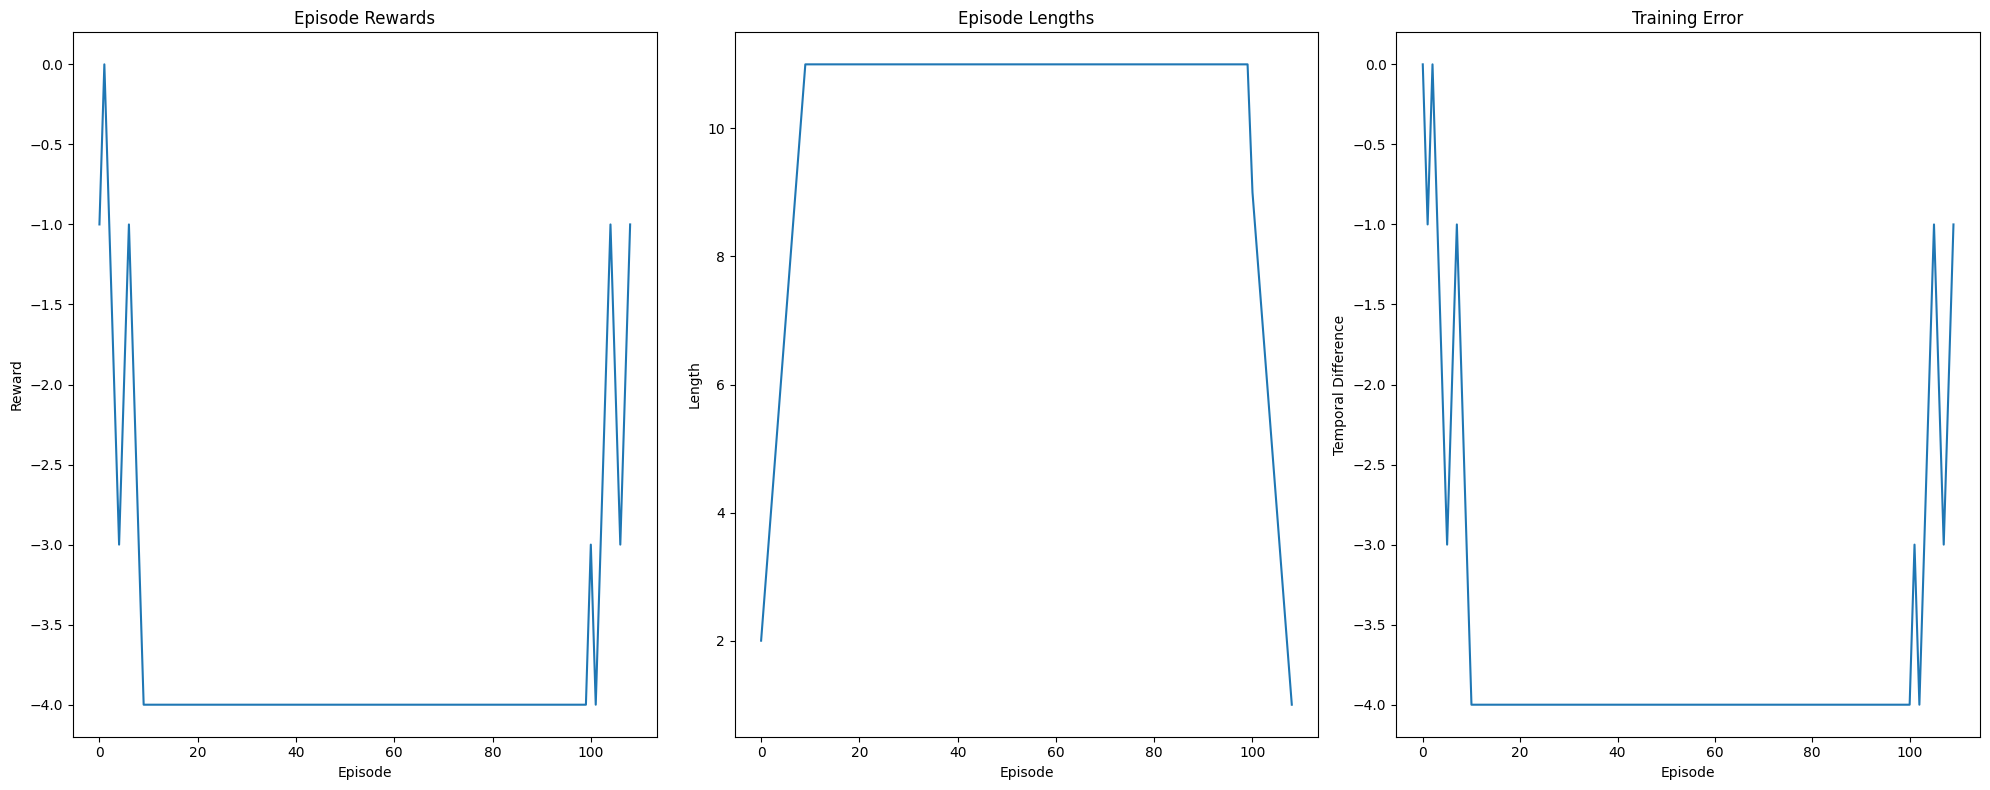

In [173]:
from matplotlib import pyplot as plt

#visualize the episode rewards, episode length and training error in one figure
fig, axs = plt.subplots(1, 3, figsize=(20,8))

# np.convolve will compute the rolling mean for 100 episodes
axs[0].plot(np.convolve(env.return_queue, np.ones(100)))
axs[0].set_title("Episode Rewards")
axs[0].set_xlabel("Episode")
axs[0].set_ylabel("Reward")

axs[1].plot(np.convolve(env.length_queue, np.ones(100)))
axs[1].set_title("Episode Lengths")
axs[1].set_xlabel("Episode")
axs[1].set_ylabel("Length")

axs[2].plot(np.convolve(agent.training_error, np.ones(100)))
axs[2].set_title("Training Error")
axs[2].set_xlabel("Episode")
axs[2].set_ylabel("Temporal Difference")

plt.tight_layout()
plt.show()
